In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import preprocessing
import itertools
import sys

sys.path.append("..")

from utility_functions import (calculate_model_performance,
                               plot_ROC,
                               one_hot_encode,
                               split_data_as,
                               grid_search)


def get_shapes(any_):
    for array in any_:
        try:
            print(array.shape)
        except:
            print("NONE")
    print("\n")


# ============= ACTIVATION FUNCTIONS ===============#

def sigmoid(Z, prime=False):
    # np.
    if prime:
        return sigmoid(Z) * (1 - sigmoid(Z))
    return 1 / (1 + np.exp(-Z))


def linear(Z, prime=False):
    if prime:
        return np.ones_like(Z)
    return Z


def relu(Z, alpha=0.01, prime=False):
    if prime:
        Z_relu = np.ones_like(Z, dtype=np.float64)
        Z_relu[Z < 0] = alpha
        return Z_relu
    return np.where(Z < 0, alpha * Z, Z)


def tanh(Z, prime=False):
    # np.tanh() could be used directly to speed this up
    if prime:
        return 1 - np.power(tanh(Z), 2)
    return (2 / (1 + np.exp(-2 * Z))) - 1


def elu(Z, prime=False):
    # https://mlfromscratch.com/activation-functions-explained/#/
    alpha = 0.2
    if prime:
        return np.where(Z < 0, alpha * (np.exp(Z)), 1)
    return np.where(Z < 0, alpha * (np.exp(Z) - 1), Z)


def softmax(Z, prime=False):
    # https://deepnotes.io/softmax-crossentropy
    # max(Z) term is added to stabilise the function.
    exps = np.exp(Z - np.max(Z))
    return exps / np.sum(exps, axis=0)


# ============== LOSS FUNCTIONS ===============#

# https://deepnotes.io/softmax-crossentropy
EPSILON = 1e-8


def calculate_error(Y, Y_hat):
    # Y and Y_hat should be in the form of (no_of_classes, no_of_training_examples)
    m = Y.shape[1]
    return -np.sum(Y * np.log(Y_hat + EPSILON)) / m


# References
# https://mc.ai/multilayered-neural-network-from-scratch-using-python/
# https://mattmazur.com/2015/03/17/a-step-by-step-backpropagation-example/
# https://www.coursera.org/learn/machine-learning/home/week/5
# https://www.coursera.org/specializations/deep-learning
# https://github.com/mnielsen/neural-networks-and-deep-learning/blob/master/src/network.py
# https://github.com/JWarmenhoven/Coursera-Machine-Learning

class NeuralNetwork:

    def __init__(
            self,
            input_layer: tuple,
            hidden_layer: list,  # list of tuples
            output_layer: int,
            batch_size=16,
            alpha=1,
            epoch=500,
            random_state=42,
            verbose=True,
            metrics="accuracy"
    ):
        self.input_layer = input_layer
        self.hidden_layer = hidden_layer
        self.output_layer = output_layer
        self.mini_batch_size = batch_size
        self.alpha = alpha
        self.epoch = epoch
        self.seed = random_state
        self.verbose = verbose
        self.metrics = metrics

        self.layers = len(self.weight_set_dimensions) + 1


    def __str__(self):
        parameters = (
            "Input layer: {0}\n"
            "Hidden layer: {1}\n"
            "Output layer: {2}\n"
            "Batch size: {3}\n"
            "Learning rate: {4}\n"
            "Epoch: {5}\n"
            "Seed: {6}\n"
            "Verbose: {7}\n"
            "Metric: {8}"
        ).format(
            self.input_layer,
            self.hidden_layer,
            self.output_layer,
            self.mini_batch_size,
            self.alpha,
            self.epoch,
            self.seed,
            self.verbose,
            self.metrics
        )
        return parameters

    def get_A(self, X):
        A, _ = self.forwardpass(X)
        return A

    def get_Z(self, X):
        _, Z = self.forwardpass(X)
        return Z

    def display_information(self, X, Y, epoch_no):
        model_performance_metrics = calculate_model_performance(
            np.argmax(Y, axis=0),
            self.predict(X)
        )
        print("%s: %.10f - epoch %s    iteration %s - loss %.20f" % (
            self.metrics,
            model_performance_metrics[self.metrics],
            epoch_no,
            self.no_of_iterations,
            calculate_error(Y,
                            self.get_A(X)[-1])
        )
              )

    def get_dimensions_and_activations(self):
        self.dimensions = []
        self.activation_functions = []

        self.dimensions.append(self.input_layer[0])
        self.activation_functions.append(self.input_layer[1])

        for dim, act_func in self.hidden_layer:
            self.dimensions.append(dim)
            self.activation_functions.append(act_func)

        self.dimensions.append(self.output_layer)

    @property
    def weight_set_dimensions(self):
        self.get_dimensions_and_activations()
        a, b = itertools.tee(self.dimensions[::-1])
        next(b, None)
        weight_set_dimensions = list(zip(a, b))[::-1]
        return weight_set_dimensions

    def initialise_weights(self, layer=None):
        self.W = np.empty_like(range(self.layers), dtype=object)
        self.B = np.empty_like(range(self.layers), dtype=object)
        self.W[0] = None
        self.B[0] = None
        for layer, (y, x) in zip(range(1, self.layers), self.weight_set_dimensions):
            np.random.seed(self.seed)
            self.W[layer] = np.random.rand(y, x) / np.sqrt(self.dimensions[layer - 1])
            self.B[layer] = np.random.rand(y, 1)

    def forwardpass(self, X):
        Z = np.empty_like(range(self.layers), dtype=object)
        A = np.empty_like(range(self.layers), dtype=object)
        A[0] = X
        Z[0] = None
        for layer in range(1, self.layers):
            # activation_function starts from 0 whereas layer starts from 1
            active_function = self.activation_functions[layer - 1]
            arg_to_pass_to_eval = "(Z[layer])"

            Z[layer] = self.W[layer] @ A[layer - 1] + self.B[layer]
            A[layer] = eval(active_function + arg_to_pass_to_eval)
        return A, Z

    def backpropagation(self, Y, A, Z):
        self.delta = np.empty_like(range(self.layers), dtype=object)
        self.delta[0] = None

        self.gradient_W = np.empty_like(range(self.layers), dtype=object)
        self.gradient_B = np.empty_like(range(self.layers), dtype=object)
        self.gradient_W[0] = None
        self.gradient_B[0] = None

        self.delta[-1] = A[-1] - Y

        # We substract 1 here as delta_final is calculated seperately above
        for layer in reversed(range(1, self.layers - 1)):
            # 1 is substracted from layer as activation_functions start indexing from 0
            active_function = self.activation_functions[layer - 1]
            arg_to_pass_to_eval = "(Z[layer], prime=True)"

            self.delta[layer] = (
                    self.W[layer + 1].T @ self.delta[layer + 1] *
                    eval(active_function + arg_to_pass_to_eval)
            )

            # calculate the gradient

        for layer in range(1, self.layers):
            self.gradient_W[layer] = (self.delta[layer] @ A[layer - 1].T) / self.m
            self.gradient_B[layer] = np.sum(self.delta[layer], axis=1, keepdims=True) / self.m

        # update the weights
        for layer in range(1, self.layers):
            self.W[layer] -= self.alpha * self.gradient_W[layer]
            self.B[layer] -= self.alpha * self.gradient_B[layer]

    def fit(self, X, Y):
        self.m = X.shape[1] # where (no_of_features, no_of_training_examples)
        self.initialise_weights()

        # By default the method is SGD(Stochastic Gradient Descent) if one wishes to use
        # the whole batch, simply pass the number of traning examples available as the
        # batch size when instantiating the class
        self.no_of_iterations = 0
        shuffled = np.arange(self.m)
        if self.verbose:
            print("Initialising weights...")
            print("Starting the training...")
            print("Initial cost: %.10f\n" % calculate_error(Y, self.get_A(X)[-1]))
        for epoch_no in range(1, self.epoch + 1):
            np.random.shuffle(shuffled)
            X_shuffled = X[:, shuffled]
            Y_shuffled = Y[:, shuffled]
            for i in range(0, self.m, self.mini_batch_size):
                self.no_of_iterations += 1
                X_mini_batch = X_shuffled[:, i: i + self.mini_batch_size]
                Y_mini_batch = Y_shuffled[:, i: i + self.mini_batch_size]

                A, Z = self.forwardpass(X_mini_batch)
                self.backpropagation(Y_mini_batch, A, Z)
                if self.no_of_iterations % 5000 == 0 and self.verbose:
                    self.display_information(X, Y, epoch_no)

    def predict(
            self,
            X: np.ndarray,
            return_prob_matrix=False
    ):
        """Predict the output given the training data.

            Returns the predicted values in two forms:

            1.either by picking up the highest value along the columns for every row,
                i.e. "np.argmax(self.A[-1].T, axis=1)"
            2.or by returning a matrix that is in the shape of Y.T where each column
                represents the probability of the instance belonging to that class.
                Please note that every column in Y.T represents a class. To be able to
                return the probability matrix, the final activation function must be
                softmax!
                i.e. "array([0.9650488423, 0.0354737543, 0.0005225966])"

        Args:
            X (numpy.ndarray): Training set in the shape of
                (no_of_features, no_of_training examples).
            return_prob_matrix (bool, optional): Returns the probability matrix if True.
                Defaults to False.

        Returns:
            numpy.ndarray:

            if return_prob_matrix is False, the output is in the shape of
                (no_of_training_examples, 1)
            if return_prob_matrix is True, the output is in the shape of
                (no_of_training_examples, no_of_features)
        """
        A, Z = self.forwardpass(X)
        if return_prob_matrix:
            np.set_printoptions(precision=10, suppress=True)
            return A[-1].T
        return np.argmax(A[-1].T, axis=1)

# Testing with benchmark datasets

## 1.Iris Dataset

In [2]:
from sklearn.datasets import load_iris
data = load_iris()

x = data.data[:,[0,2]]
y = data.target

X = x.T
Y = one_hot_encode(y).T

# test, train = split_data_as(x, y, train=0.8, test=0.2)

# X_train = train[:, :-1]
# Y_train = train[:, -1].reshape(-1, 1)

In [3]:
print(X.shape)
print(Y.shape)
# print("\n")
# print(X_test.shape)
# print(Y_test.shape)
# print("\n")
# print(X_validation.shape)
# print(Y_validation.shape)

(2, 150)
(3, 150)


In [4]:
results_dict_all_models, results_average_dict, models = grid_search(
    x,
    y,
    metric='F1',
    clf=NeuralNetwork,
    n_fold=3,
    param_grid_dict={
        'batch_size': [8, 16, 32, 64],
        'input_layer': [(2, 'relu'), (2, 'tanh')],
        'hidden_layer': [
            [(4,'relu'), (8,'sigmoid'), (16,'relu'), (8,'sigmoid'), (4,'softmax')],
            [(4,'relu'), (4,'relu'),(4,'softmax')],
            [(4,'sigmoid'),(4,'softmax')]
        ],
        'output_layer': [3],
        'alpha': [1, 2, 4],
        'verbose': [False],
        'epoch': [1]
    }
)


*********1/216*********
Running model 1 fold 1

*********2/216*********
Running model 1 fold 2

*********3/216*********
Running model 1 fold 3

*********4/216*********
Running model 2 fold 1

*********5/216*********
Running model 2 fold 2

*********6/216*********
Running model 2 fold 3

*********7/216*********
Running model 3 fold 1

*********8/216*********
Running model 3 fold 2

*********9/216*********
Running model 3 fold 3

*********10/216*********
Running model 4 fold 1

*********11/216*********
Running model 4 fold 2

*********12/216*********
Running model 4 fold 3

*********13/216*********
Running model 5 fold 1

*********14/216*********
Running model 5 fold 2

*********15/216*********
Running model 5 fold 3

*********16/216*********
Running model 6 fold 1

*********17/216*********
Running model 6 fold 2

*********18/216*********
Running model 6 fold 3

*********19/216*********
Running model 7 fold 1

*********20/216*********
Running model 7 fold 2

*********21/216*********
Run

In [6]:
models

{'model_1': <__main__.NeuralNetwork at 0x151a06b0>,
 'model_10': <__main__.NeuralNetwork at 0x73254b0>,
 'model_11': <__main__.NeuralNetwork at 0x151350d0>,
 'model_12': <__main__.NeuralNetwork at 0x14ee1530>,
 'model_13': <__main__.NeuralNetwork at 0x14ec4dd0>,
 'model_14': <__main__.NeuralNetwork at 0x151a0c90>,
 'model_15': <__main__.NeuralNetwork at 0x151a0bb0>,
 'model_16': <__main__.NeuralNetwork at 0x151a0a10>,
 'model_17': <__main__.NeuralNetwork at 0x151a06f0>,
 'model_18': <__main__.NeuralNetwork at 0x151a0670>,
 'model_19': <__main__.NeuralNetwork at 0x13a49e50>,
 'model_2': <__main__.NeuralNetwork at 0xfcbf830>,
 'model_20': <__main__.NeuralNetwork at 0x13a49a90>,
 'model_21': <__main__.NeuralNetwork at 0x14ec4b70>,
 'model_22': <__main__.NeuralNetwork at 0x73253d0>,
 'model_23': <__main__.NeuralNetwork at 0x1518fc30>,
 'model_24': <__main__.NeuralNetwork at 0x7325450>,
 'model_25': <__main__.NeuralNetwork at 0x151a0e30>,
 'model_26': <__main__.NeuralNetwork at 0x151a0770>,

In [7]:
calculate_model_performance(
    np.argmax(Y, axis=0),
    models["model_17"].predict(X)
)

{'F1': 0.0,
 'accuracy': 33.33333333311111,
 'false_positive_rate': 49.9999999995,
 'precision': 0.0,
 'prevalence': 33.33333333311111,
 'sensitivity/recall': 0.0,
 'specificity': 49.9999999995}

In [8]:
print(models["model_17"])

Input layer: (2, 'tanh')
Hidden layer: [(4, 'sigmoid'), (4, 'softmax')]
Output layer: 3
Batch size: 8
Learning rate: 2
Epoch: 1
Seed: 42
Verbose: False
Metric: accuracy


In [ ]:
%matplotlib notebook
import matplotlib.pyplot as plt
dt = data.data[:,[0,2]]
x_min, x_max = dt[:, 0].min() - 1, dt[:, 0].max() + 1
y_min, y_max = dt[:, 1].min() - 1, dt[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))

# here "model" is your model's prediction (classification) function
Z = models["model_17"].predict(np.c_[xx.ravel(), yy.ravel()].T) 

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure(figsize=(12,8))
plt.contourf(xx, yy, Z,alpha=0.4)
#plt.axis('off')

plt.scatter(dt[:, 0], dt[:, 1], c=y,s=20, edgecolor='k')
plt.xlabel('sepal length')
plt.ylabel('petal length')

plt.contour(xx, yy, Z, [0.5], linewidths=2, colors="g")

## 2.Make Moons dataset

In [ ]:
from sklearn.datasets import make_moons

x,y =make_moons(n_samples=1500, noise=.05)
X = x.T
Y = one_hot_encode(y).T

print(X.shape)
print(Y.shape)

In [ ]:
model = NeuralNetwork(
    input_layer=(2, "sigmoid"),
    hidden_layer=[(8, "tanh"),
                  (6, "relu"),
                  (4, "softmax")],
    output_layer=2,
    batch_size=64,
    alpha=0.5,
    epoch=2500,
    random_state=42
)


model.fit(X, Y)

In [ ]:
### Decision Boundaries
%matplotlib inline
import matplotlib.pyplot as plt
dt = x
x_min, x_max = dt[:, 0].min() - 0.5, dt[:, 0].max() + 0.5
y_min, y_max = dt[:, 1].min() - 0.5, dt[:, 1].max() + 0.5
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))

# here "model" is your model's prediction (classification) function
Z = model.predict(np.c_[xx.ravel(), yy.ravel()].T) 

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure(figsize=(12,8))
plt.contourf(xx, yy, Z,alpha=0.4)
#plt.axis('off')
plt.scatter(dt[:, 0], dt[:, 1], c=y, s=20, edgecolor='k')
plt.title('Decision Boundaries')

## 3.Andrew NG Assignment 2 Dataset

In [20]:
ex2data2 = np.loadtxt("../ex2/data/ex2data2.txt", delimiter=",")

x = ex2data2[:, :-1]
y = ex2data2[:, -1]

X = X.T
Y = one_hot_encode(y).T

In [21]:
print(X.shape)
print(Y.shape)

(3, 118)
(2, 118)


In [ ]:
results_dict_all_models, results_average_dict, models = grid_search(
    x,
    y,
    metric='F1',
    clf=NeuralNetwork,
    n_fold=3,
    param_grid_dict={
        'batch_size': [8, 16, 32],
        'input_layer': [(2, 'relu'), (2, 'tanh')],
        'hidden_layer': [
            [(4,'relu'), (8,'sigmoid'), (16,'relu'), (8,'sigmoid'), (4,'softmax')],
            [(4,'relu'), (4,'relu'),(4,'softmax')],
            [(4,'sigmoid'),(4,'softmax')]
        ],
        'output_layer': [2],
        'alpha': [0.5, 2, 4],
        'verbose': [False],
        'epoch': [10000]
    }
)


*********1/162*********
Running model 1 fold 1

*********2/162*********
Running model 1 fold 2


In [24]:
results_average_dict

[('model_47', 70.81000759906118),
 ('model_17', 70.35176554804058),
 ('model_11', 69.99717487121468),
 ('model_28', 69.65305225763986),
 ('model_29', 69.22015182529223),
 ('model_14', 69.11644563414607),
 ('model_36', 67.7600919888149),
 ('model_53', 67.4199960208186),
 ('model_46', 67.30158729772423),
 ('model_50', 66.99074073663523),
 ('model_51', 66.65110488256515),
 ('model_54', 65.77326538412628),
 ('model_18', 65.71428571011351),
 ('model_9', 65.53856509345084),
 ('model_32', 65.30692182458787),
 ('model_44', 65.05596505241765),
 ('model_35', 64.90708478147435),
 ('model_10', 64.84905958221239),
 ('model_33', 64.63203462811475),
 ('model_12', 63.52928913584623),
 ('model_15', 62.6082251043139),
 ('model_7', 62.34034698790952),
 ('model_26', 59.84240053648949),
 ('model_8', 58.80574451659507),
 ('model_25', 58.79643769265733),
 ('model_43', 44.24103737360431),
 ('model_27', 29.61287078735877),
 ('model_42', 22.641509432951235),
 ('model_30', 20.155038758588066),
 ('model_24', 17.7

In [25]:
print(models[results_average_dict[0][0]])

Input layer: (2, 'tanh')
Hidden layer: [(4, 'relu'), (4, 'relu'), (4, 'softmax')]
Output layer: 2
Batch size: 32
Learning rate: 2
Epoch: 500
Seed: 42
Verbose: False
Metric: accuracy


C:\Anaconda3\lib\site-packages\numpy\ma\core.py:6461: MaskedArrayFutureWarning: In the future the default for ma.maximum.reduce will be axis=0, not the current None, to match np.maximum.reduce. Explicitly pass 0 or None to silence this warning.
  return self.reduce(a)
C:\Anaconda3\lib\site-packages\numpy\ma\core.py:6461: MaskedArrayFutureWarning: In the future the default for ma.minimum.reduce will be axis=0, not the current None, to match np.minimum.reduce. Explicitly pass 0 or None to silence this warning.
  return self.reduce(a)


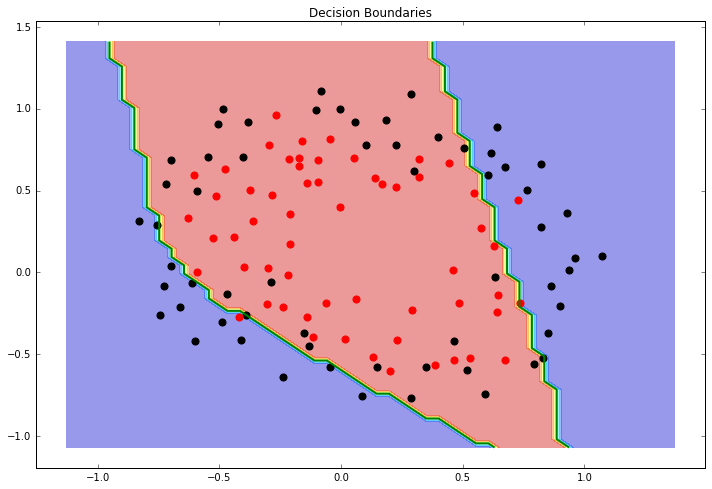

In [26]:
### Decision Boundaries
%matplotlib inline
import matplotlib.pyplot as plt
X = ex2data2

x1_min, x1_max = X[:, 0].min() - 0.3, X[:, 0].max() + 0.3,
x2_min, x2_max = X[:, 1].min() - 0.3, X[:, 1].max() + 0.3,
xx1, xx2 = np.meshgrid(np.linspace(x1_min, x1_max), np.linspace(x2_min, x2_max))

# here "model" is your model's prediction (classification) function
Z = models["model_47"].predict(np.c_[xx1.ravel(), xx2.ravel()].T) 

negatives = ex2data2[ex2data2[:, -1] == 0]
positives = ex2data2[ex2data2[:, -1] == 1]

# Put the result into a color plot
Z = Z.reshape(xx1.shape)
plt.figure(figsize=(12,8))
plt.contourf(xx1, xx2, Z,alpha=0.4)
#plt.axis('off')
plt.scatter(negatives[:, 0], negatives[:, 1],s=50, color='k')
plt.scatter(positives[:, 0], positives[:, 1],s=50, color='r')
plt.title('Decision Boundaries')

plt.contour(xx1, xx2, Z, [0.5], linewidths=2, colors="g")

# MNIST dataset

In [ ]:
from scipy.io import loadmat
data = loadmat('../ex3/data/ex3data1.mat')
data.keys()

In [ ]:
x = data["X"]
y = data["y"]

In [ ]:
train, test, validation = split_data_as(x,y, train=0.6, test=0.2, validation=0.2)

X_train = train[:, :-1].T
Y_train = one_hot_encode(train[:, -1]).T

X_test = test[:, :-1].T
Y_test = one_hot_encode(test[:, -1]).T

X_validation = validation[:, :-1].T
Y_validation = one_hot_encode(validation[:, -1]).T

In [ ]:
print(X_train.shape)
print(Y_train.shape)
print("\n")
print(X_test.shape)
print(Y_test.shape)
print("\n")
print(X_validation.shape)
print(Y_validation.shape)

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(20,20))

sample = np.random.choice(data["X"].shape[0], 20)
ax.imshow(data["X"][sample,1:].reshape(-1,20).T)
ax.axis('off');

In [ ]:
model = NeuralNetwork(
    input_layer=(X_train.shape[0], "relu"),
    hidden_layer=[(10, "relu"),
                  (10, "softmax")],
    output_layer=Y_train.shape[0],
    batch_size=16,
    alpha=0.2,
    epoch=500,
    random_state=12
)


model.fit(X_train, Y_train)

In [ ]:
np.sum(model.predict(X_train) == np.argmax(Y_train,axis=0))

In [ ]:
calculate_model_performance(
    np.argmax(Y_train,axis=0),
    model.predict(X_train)
)

In [ ]:
for index, (act, predicted) in enumerate(zip(np.argmax(Y_train,axis=0), model.predict(X_train))):
    if act != predicted:
        fig, ax = plt.subplots(figsize = (2,2))
        ax.set_title("%s: act %s --- predicted %s" %(index, act + 1, predicted + 1))
        ax.imshow(X_train[:, index].reshape(-1,20).T)
        ax.axis('off');

In [ ]:
calculate_model_performance(
    np.argmax(Y_test,axis=0),
    model.predict(X_test)
)

In [ ]:
for index, (act, predicted) in enumerate(zip(np.argmax(Y_test,axis=0), model.predict(X_test))):
    if act != predicted:
        fig, ax = plt.subplots(figsize = (2,2))
        ax.set_title("%s: act %s --- predicted %s" %(index, act + 1, predicted + 1))
        ax.imshow(X_test[:, index].reshape(-1,20).T)
        ax.axis('off');

In [ ]:
def cross_validation():
    pass